# NN Practice on CIFAR Dataset

## Importing Libraries

In [1]:
# Basics
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# For CNN
import torch.nn as nn
import torch.nn.functional as F

# For Loss Func. And Optimization
import torch.optim as optim

# For Visual Representation
import matplotlib.pyplot as plt

print("Success")

Success


## Setup Dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Number of samples processed before updating model
batch_size = 4 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
# Image Categories
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

print("Success")

Files already downloaded and verified
Files already downloaded and verified
Success


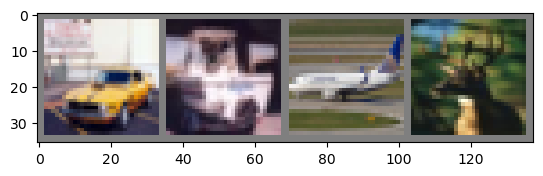

automobile ship  airplane deer 


In [5]:
# Show image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Randomly selected training img
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Setup CNN

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Dropout Layers
        self.dropout1 = nn.Dropout(0.5)  

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x
net = Net()

In [13]:
# Setting up loss func. and optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = .001, momentum = 0.9, weight_decay=.001)
# optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.RMSprop(net.parameters(), lr=0.001)
# optimizer = optim.Adagrad(net.parameters(), lr=0.01)
# optimizer = optim.Nadam(net.parameters(), lr=0.002)

## Training

In [14]:
from sklearn.model_selection import KFold

# Set up CUDA
if torch.cuda.is_available():
    print("Available")
    device = torch.device("cuda")
    print("")

# Enabling cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
    train_dataset = torch.utils.data.Subset(trainset, train_idx)
    val_dataset = torch.utils.data.Subset(trainset, val_idx)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

    net.to(device)  # Reinitialize the model for each fold

    for epoch in range(5):  # looping over dataset
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        net.train()

        for images, labels in trainloader:
            # get inputs
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # return statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Print training loss and accuracy per epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader):.3f}, Training Accuracy: {100 * train_accuracy:.2f}%')

        # Validation phase
        net.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # calculate accuracy for validation
                _, predicted = torch.max(outputs.data, 1)
                val_total_samples += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_accuracy = val_correct_predictions / val_total_samples

        # Print loss and accuracy per epoch for both training and validation
        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(valloader)}, Validation Accuracy: {val_accuracy:.2%}')
        print("")

print("Training Complete")

Available

Fold 1, Epoch 1, Training Loss: 1.678, Training Accuracy: 37.94%
Epoch 1, Validation Loss: 11.800104590761661, Validation Accuracy: 52.54%

Fold 1, Epoch 2, Training Loss: 1.228, Training Accuracy: 55.89%
Epoch 2, Validation Loss: 8.840645084872842, Validation Accuracy: 65.59%

Fold 1, Epoch 3, Training Loss: 1.037, Training Accuracy: 63.41%


KeyboardInterrupt: 

In [61]:
# ISSUE - DO NOT USE
from sklearn.model_selection import KFold

# Set up CUDA
if torch.cuda.is_available():
    print("Available")
    device = torch.device("cuda")
    print("")

# Enabling cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
    train_dataset = torch.utils.data.Subset(trainset, train_idx)
    val_dataset = torch.utils.data.Subset(trainset, val_idx)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

    net.to(device)  # Reinitialize the model for each fold

    for epoch in range(5):  # looping over dataset
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        net.train()

        for i, data in enumerate(trainloader, 0):
            # get inputs
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # return statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Print training loss and accuracy per epoch
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader):.3f}, Training Accuracy: {100 * train_accuracy:.2f}%')

        # Validation phase
        net.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for i, data in enumerate(valloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # calculate accuracy for validation
                _, predicted = torch.max(outputs.data, 1)
                val_total_samples += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_accuracy = val_correct_predictions / val_total_samples

        # Print loss and accuracy per epoch for both training and validation
        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(valloader)}, Validation Accuracy: {val_accuracy:.2%}')
        print("")

print("Training Complete")

Available

Fold 1, Epoch 1, Training Loss: 5.886, Training Accuracy: 46.55%
Epoch 1, Validation Loss: 36.49781382983923, Validation Accuracy: 63.88%

Fold 1, Epoch 2, Training Loss: 3.888, Training Accuracy: 65.52%
Epoch 2, Validation Loss: 27.35404861894995, Validation Accuracy: 73.35%

Fold 1, Epoch 3, Training Loss: 3.082, Training Accuracy: 72.81%
Epoch 3, Validation Loss: 21.412752917171144, Validation Accuracy: 79.98%

Fold 1, Epoch 4, Training Loss: 2.461, Training Accuracy: 78.51%
Epoch 4, Validation Loss: 17.110354288185402, Validation Accuracy: 83.27%



## Saving Model

In [7]:
PATH = './Models/cifar_net_kfold.pth'
torch.save(net.state_dict(), PATH)

## Testing Data

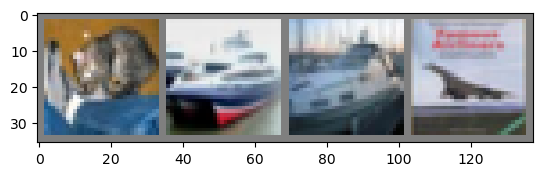

Truth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show img from test set
imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
# loading saved model
net = Net()
net.load_state_dict(torch.load('./Models/cifar_net_kfold.pth'))

# Testing against above images
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  dog   ship  ship  plane


In [13]:
# Now test on entire dataset
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        # Pick class with highest similarity score
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


In [14]:
# Breakdown
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.8 %
Accuracy for class: car   is 84.1 %
Accuracy for class: bird  is 63.8 %
Accuracy for class: cat   is 49.2 %
Accuracy for class: deer  is 66.7 %
Accuracy for class: dog   is 66.6 %
Accuracy for class: frog  is 81.0 %
Accuracy for class: horse is 78.8 %
Accuracy for class: ship  is 82.0 %
Accuracy for class: truck is 78.0 %


In [15]:
def write_accuracy_to_file(filename, correct, total, correct_pred, total_pred):
    # Open the specified text file in write mode
    with open(filename, 'w') as file:
        # Write overall accuracy to the file
        file.write(f'Total Epochs: {5}\n\n')
        file.write(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n\n')

        # Write accuracy for each class to the file
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            file.write(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %\n')

In [16]:
# Provide a filename (e.g., 'my_accuracy_results.txt') as an argument
write_accuracy_to_file('cifar_net_cross_validation_accuracy.txt', correct, total, correct_pred, total_pred)